# Compare Long, Short-Term Memory (LSTM) Model to Heston Model
Author: Amaris Williams, PhD

Date: October 2025

This analysis is loosely based on https://doi.org/10.21203/rs.3.rs-7509723/v1
### Set Up Environment

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.optimize import minimize

# functions from Thomas Polstra
import usefulfuncs.funclist as uf

np.random.seed(222)

### Load and process stock data

In [2]:
path = "/home/anw/Documents/Python/Data/"
df = pd.read_csv(str(path) + "fs1test.csv", 
                 header = [0,1], index_col = 0)

stock_symbol = 'SPY'
ticker = yf.Ticker(stock_symbol)
stock_data = yf.download(stock_symbol, period = '5d', interval = '1m')

expirations = ticker.options

# Create array to store options data
option_data = []

for date in expirations:
    chain = ticker.option_chain(date)

    # Add expiration and label
    calls = chain.calls.copy()
    calls['expiration'] = date

    option_data.append(calls)

# Combine all into one DataFrame and delete implied volatility column since we're using LSTM.
options_data = pd.concat(option_data, ignore_index=True)
options_data = options_data.drop(columns=['impliedVolatility'])

# Delete any options that were NOT traded in the interval of historical stock values obtained
start_date = stock_data.index[0]
options_data = options_data[options_data['lastTradeDate']>=start_date]

# Insert column of time to expiration in years of the option contract measured from time of last trade
options_data['time_to_expiration'] = options_data.apply(
lambda row: uf.find_tte_yf_options(expiration_date = row['expiration'],
                               last_trade_date = row['lastTradeDate']),
    axis = 1
)

# Add in column of the spot price of stock when the option trade occured.
options_data['spot_price'] = options_data.apply(
    lambda row: uf.yf_find_approx_spot(stock_data['Close'], row['lastTradeDate']),
    axis=1
)

# Create data frame that keeps relevant information
options_data = options_data[['strike', 'lastPrice', 'lastTradeDate',\
                             'expiration', 'time_to_expiration', 'spot_price']]

# Add implied volatility column 
r = 0.03
options_data['implied_volatility'] = options_data.apply(
    lambda row: uf.implied_volatility_call(
        market_price=row['lastPrice'],
        S0 = row['spot_price'],
        K=row['strike'],
        t=row['time_to_expiration'],
        r=r
    ),
    axis=1
)

options_data = options_data.dropna()

options_data

/tmp/ipykernel_66448/1949576034.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, period = '5d', interval = '1m')
[*********************100%***********************]  1 of 1 completed


,strike,lastPrice,lastTradeDate,expiration,time_to_expiration,spot_price,implied_volatility
27,540.0,133.04,2025-11-06 20:04:07+00:00,2025-11-07,0.002903,672.770020,1.787576
28,545.0,124.89,2025-11-06 18:19:19+00:00,2025-11-07,0.003103,669.659973,1.588254
40,605.0,56.35,2025-11-07 17:07:07+00:00,2025-11-07,0.000500,661.219971,1.798476
41,610.0,53.34,2025-11-07 17:45:23+00:00,2025-11-07,0.000427,663.150024,1.955575
43,620.0,43.16,2025-11-07 17:46:57+00:00,2025-11-07,0.000424,663.119995,1.294915
...,...,...,...,...,...,...,...
3736,1005.0,2.70,2025-11-07 17:28:06+00:00,2028-01-21,2.205940,663.479980,0.135869
3737,1010.0,3.27,2025-11-04 19:03:54+00:00,2028-01-21,2.213977,676.494995,0.135683
3738,1020.0,2.44,2025-11-07 14:54:21+00:00,2028-01-21,2.206232,666.094971,0.136439
3739,1025.0,2.35,2025-11-06 16:48:53+00:00,2028-01-21,2.208754,669.530029,0.135200


### Visualize Call Volatility Smiles

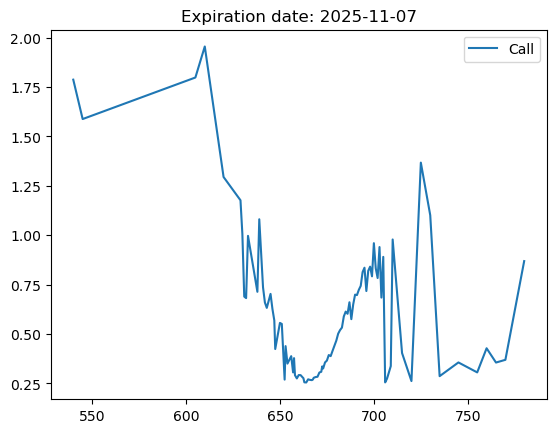

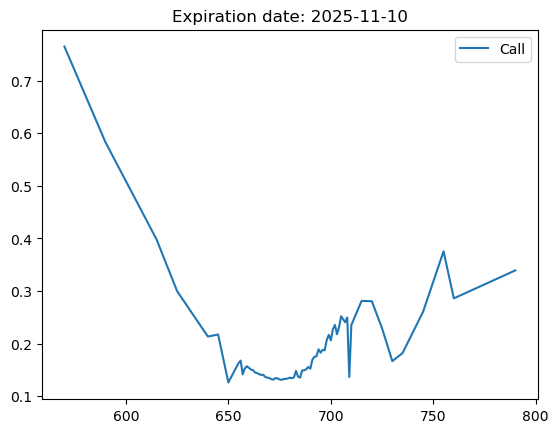

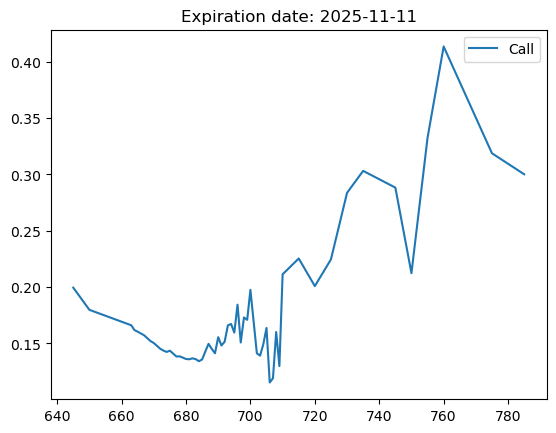

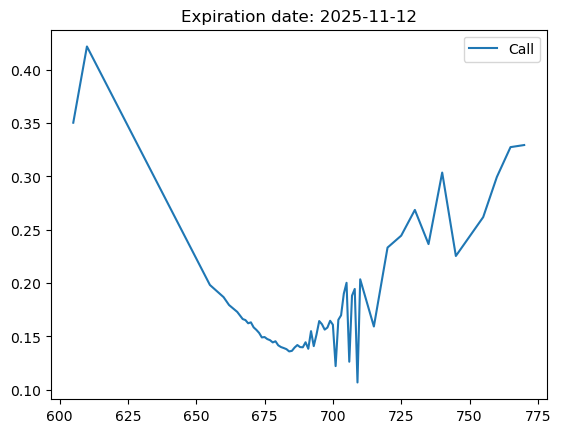

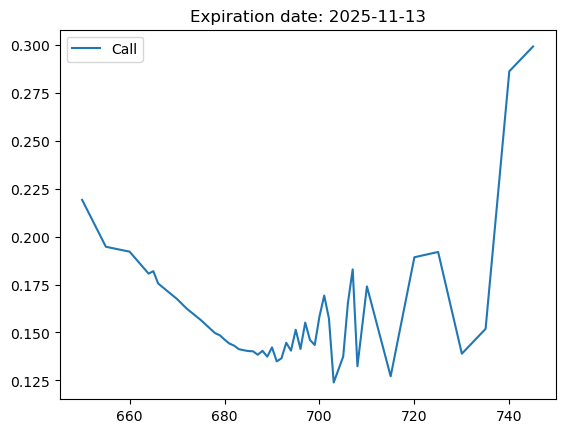

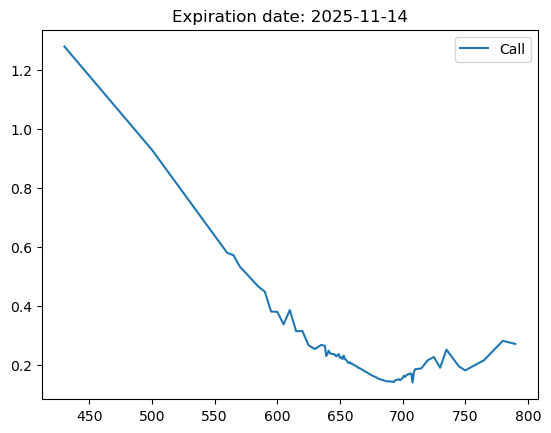

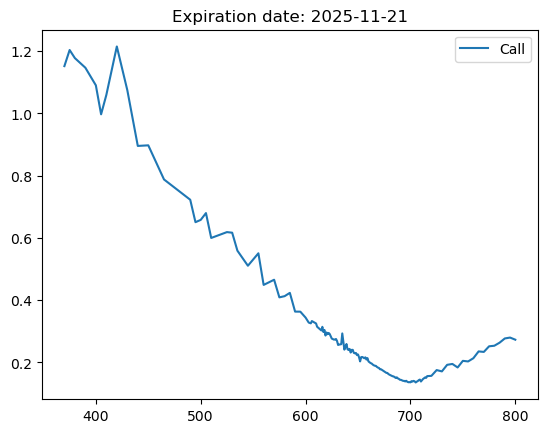

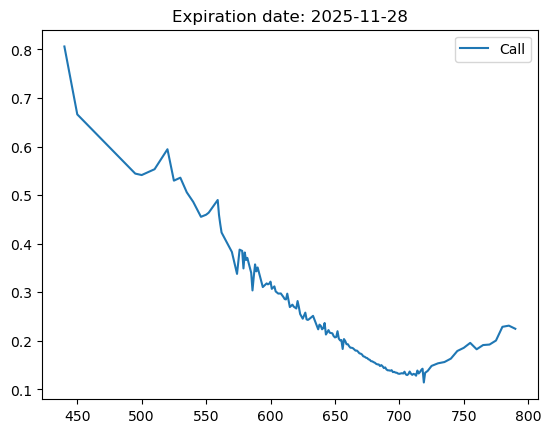

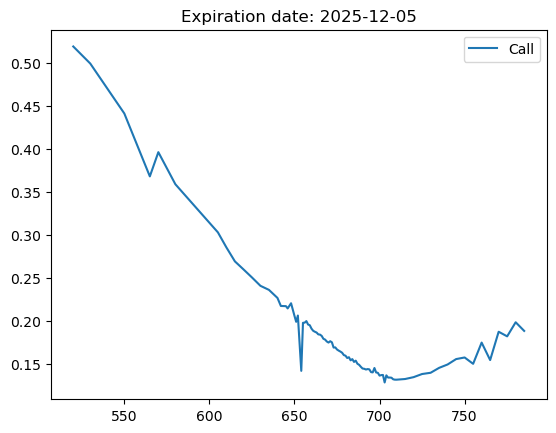

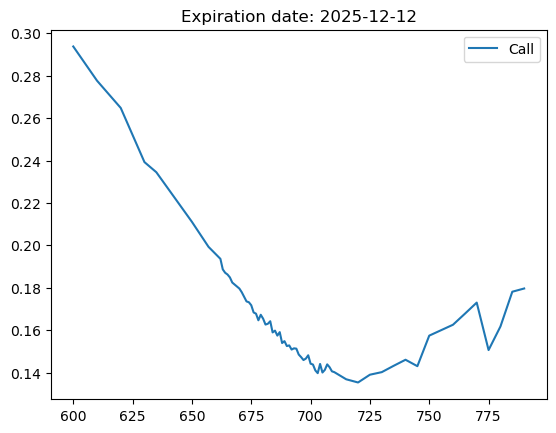

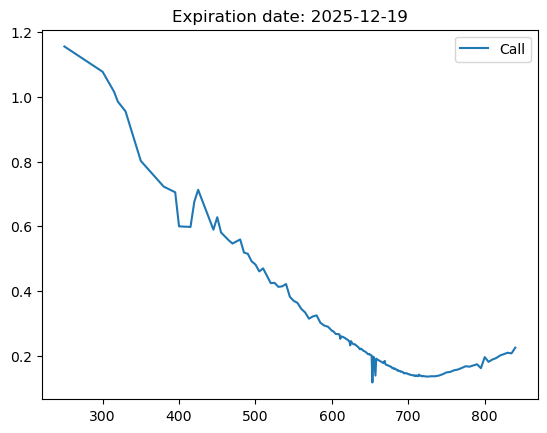

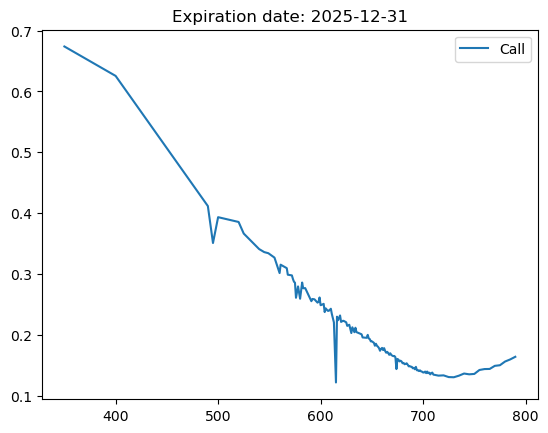

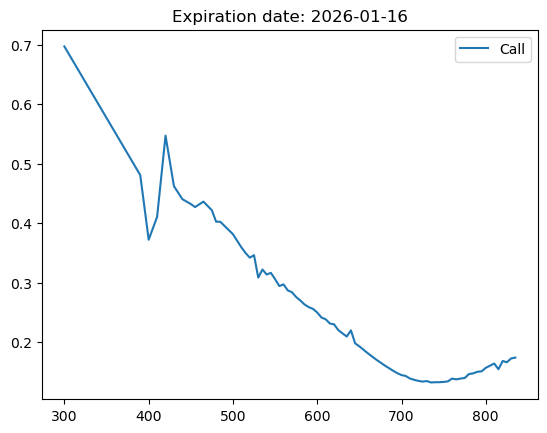

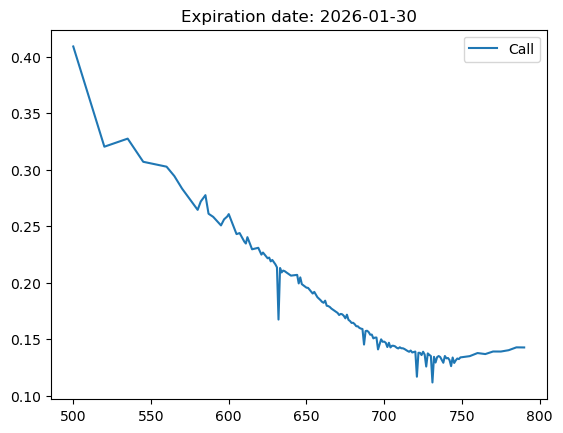

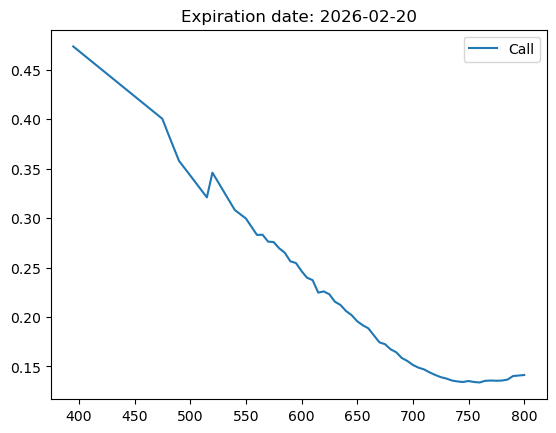

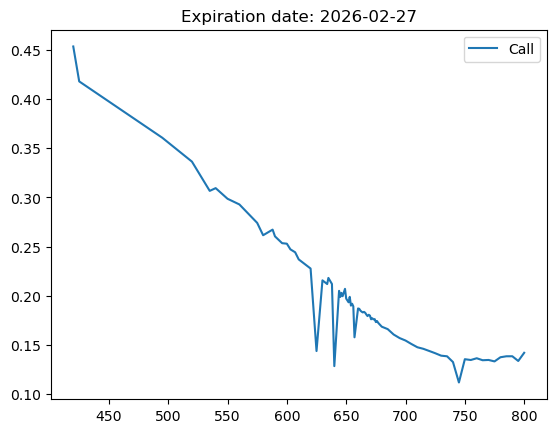

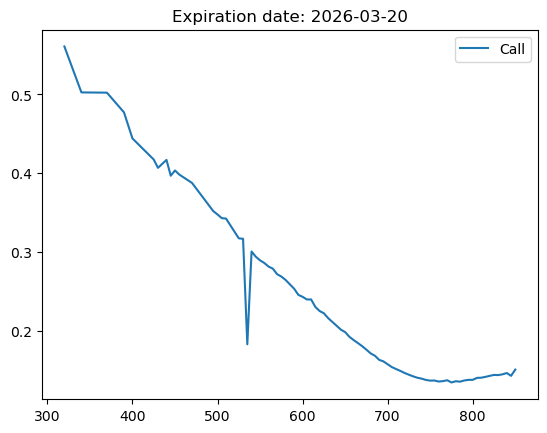

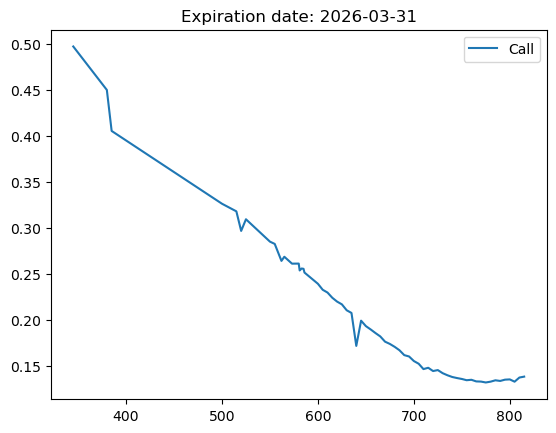

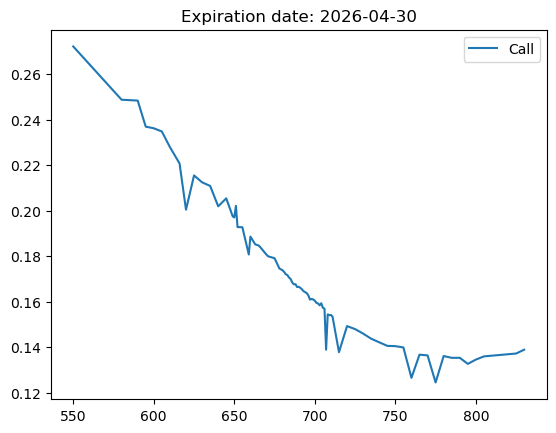

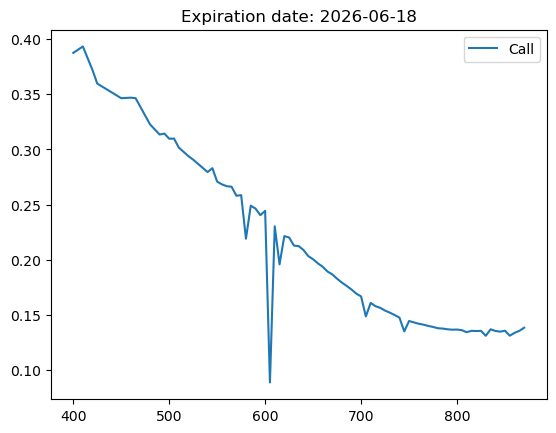

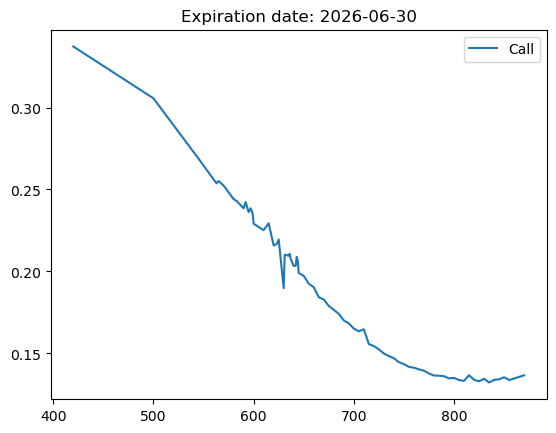

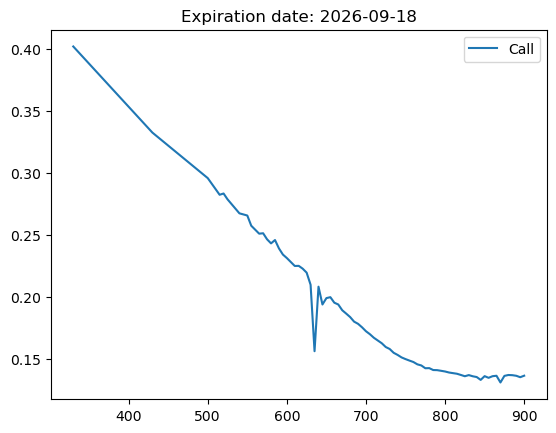

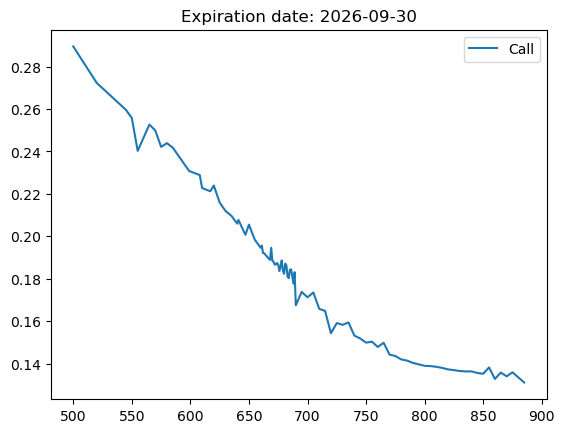

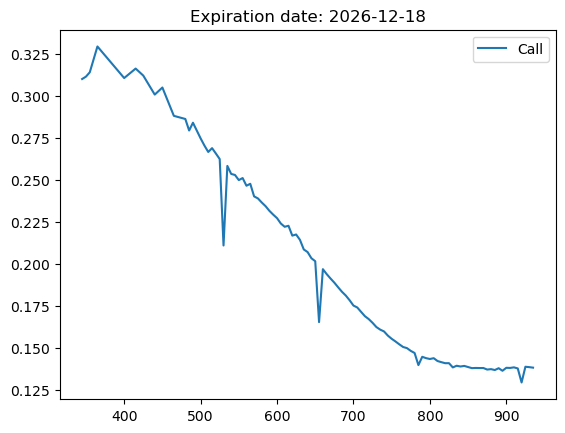

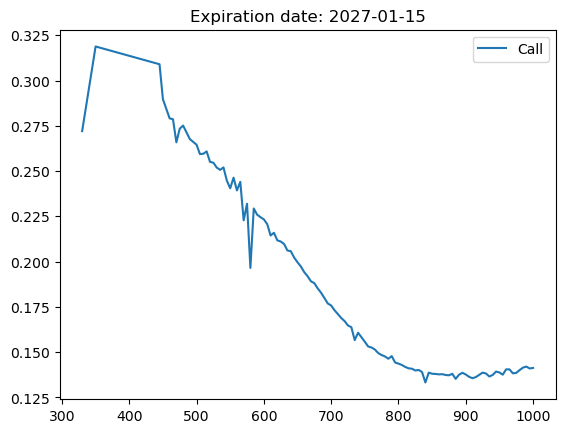

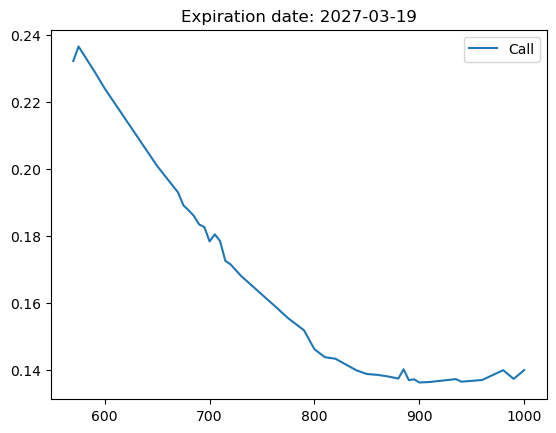

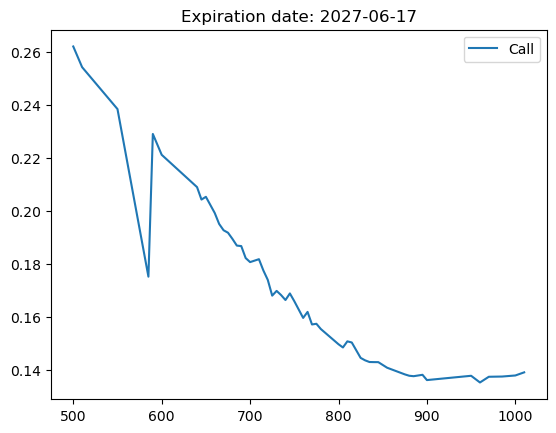

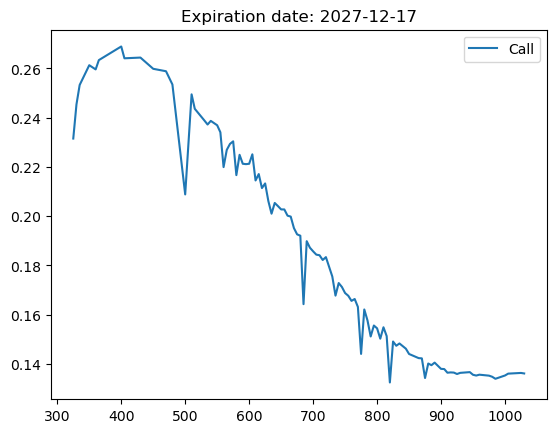

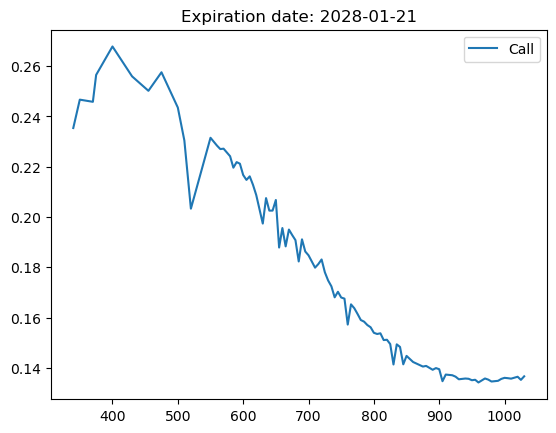

In [3]:
### Data visualization of option volatility smiles
for date in expirations:
    
    call_data = options_data[options_data['expiration'] == date]
    call_strikes = call_data['strike']
    call_imp_vol = call_data['implied_volatility']
    
    plt.plot(call_strikes.values, call_imp_vol.values, label = 'Call')
    
    plt.title(f'Expiration date: {date}')
    plt.legend()
    plt.show()

### Include only dates with reasonable smiles

In [11]:
dates = ['2027-03-19','2026-06-30',
         '2026-03-31','2026-02-20']  # dates that have reasonable volatility smiles

options_data_cleaned = options_data[options_data['expiration'].isin(dates)]


### Calibrate Heston Parameters

In [12]:
# Funciton to calculate error to minimize
def objective(params, data, r):
    kappa, v0, xi, rho, theta = params
    
    error = 0
    for _, row in data.iterrows():
        model_price = uf.heston_option(
            S0=row['spot_price'],
            K=row['strike'],
            v0=v0,
            r=r,
            t=row['time_to_expiration'],
            kappa=kappa,
            theta=theta,
            xi=xi,
            rho=rho,
            option_type = 'call'
        )
        market_price = row['lastPrice']
        error += (model_price - market_price) ** 2
        
    return error / len(data)


In [13]:
initial_guess = [3, .4**2, .6, -.6,.4**2]  #kappa, v0, xi, rho, theta
bounds = [(.01, 8), (.1**2, .9**2), (.01, 2), (-1,-0.01), (.1**2, .9**2)] 

r = .03

data_sample = options_data_cleaned.sample(30)

result = minimize(
    objective,
    initial_guess,
    args=(data_sample, r),
    bounds=bounds,
    method='L-BFGS-B',
    options={
        'disp': True,
        'maxiter': 20,       
        'ftol': 1e-4,         
        'gtol': 1e-4          
    }
)

kappa, v0, xi, rho, theta = result.x

/home/anw/Documents/Python/Erdoes/quant/quant-finance-fall-2025/projectANW/usefulfuncs/funclist.py:51: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
/home/anw/Documents/Python/Erdoes/quant/quant-finance-fall-2025/projectANW/usefulfuncs/funclist.py:52: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
/home/anw/Documents/Python/Erdoes/quant/quant-finance-fall-2025/projectANW/usefulfuncs/funclist.py:51: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P1 = 0.5 + (1 / np.pi) * quad(lambda phi: i

In [14]:
kappa, np.sqrt(v0), xi, rho, np.sqrt(theta)

(np.float64(0.9045790938147933),
 np.float64(0.2144358483388623),
 np.float64(1.4351305689742029),
 np.float64(-0.6682346495811924),
 np.float64(0.32963092768058366))

## Experiment: Compare profits using LSTM volatility to profits using past rolling volatilty
### Heston profits using past rolling volatility

In [23]:
t = 1

n_steps = 252

dt = t/n_steps

stock_path = np.array(df['Close']['^SPX'].values[-n_steps-1:])

rol_sigmas = (df['sigma_roll22']['^SPX']*np.sqrt(252))[-n_steps-1:]

rol_vols = rol_sigmas**2

K = stock_path[0]

deltas = np.zeros(n_steps)

times = np.linspace(0,t, n_steps + 1)

for i in range(n_steps):
    deltas[i] = uf.heston_call_delta(stock_path[i], K, rol_vols.iloc[i], r, (t-times)[i], kappa, theta, xi, rho)

stock_profits = (stock_path[1:n_steps+1] - stock_path[0:n_steps]*np.exp(r*dt))*np.exp(-r*times[1:n_steps+1])*deltas

total_stock_profit = np.sum(stock_profits)

call_payout = np.maximum(stock_path[-1] - K, 0)*np.exp(-r*t)

call_profit_hedged = -call_payout + total_stock_profit

heston_call_price = uf.heston_call(stock_path[0], K, rol_vols.iloc[0], r, t, kappa, theta, xi, rho)

profit = heston_call_price + call_profit_hedged

print(f'Profit per 100 contracts: ${profit*100:.2f}')

Profit per 100 contracts: $57.26


### Heston profits using LSTM volatilty predictions

In [24]:
LSTM = load_model(str(path) + 'fs1model.keras')

def create_3Darray(Xdata, ydata, lookback):
    if len(Xdata) == len(ydata):
        X, y = [], []
        for i in range(len(Xdata) - lookback):
            X.append(Xdata[i:i+lookback])      # sequence of lookback timesteps
            y.append(ydata[i+lookback])
        return np.array(X), np.array(y)
    else:
        raise Exception("Xdata must be same length as ydata.")

lookback = 22

fs1, hold = create_3Darray(df, np.zeros(len(df)), lookback)
del(hold)

predictions = LSTM.predict(fs1, verbose = 2)

yscaler = joblib.load(str(path) + 'yscaler.gz')
predictions = yscaler.inverse_transform(predictions)

predictions = pd.DataFrame(predictions, columns=["fut_sigma_1","fut_sigma_5","fut_sigma_22"])

rol_sigmas = (predictions['fut_sigma_22']*np.sqrt(252))[-n_steps-1:]

rol_vols = rol_sigmas**2

deltas = np.zeros(n_steps)

for i in range(n_steps):
    deltas[i] = uf.heston_call_delta(stock_path[i], K, rol_vols.iloc[i], r, (t-times)[i], kappa, theta, xi, rho)

stock_profits = (stock_path[1:n_steps+1] - stock_path[0:n_steps]*np.exp(r*dt))*np.exp(-r*times[1:n_steps+1])*deltas

total_stock_profit = np.sum(stock_profits)

call_payout = np.maximum(stock_path[-1] - K, 0)*np.exp(-r*t)

call_profit_hedged = -call_payout + total_stock_profit

heston_call_price = uf.heston_call(stock_path[0], K, rol_vols.iloc[0], r, t, kappa, theta, xi, rho)

proftit = heston_call_price + call_profit_hedged

print(f'Profit per 100 contracts: ${profit*100:.2f}')

18/18 - 0s - 8ms/step
Profit per 100 contracts: $57.26


No difference